Visualize and validate different spatial binning methods (quadtree, 3x3, regional) with event distributions, cell boundaries, and metadata for each bin.

In [21]:
%pip install csep

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement csep (from versions: none)
ERROR: No matching distribution found for csep


In [22]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  # adjust if needed
if project_root not in sys.path:
    sys.path.append(project_root)

from csep.core.catalogs import CSEPCatalog
from src.preprocessing.load_catalog import load_catalog
from src.binning.quadtree import apply_quadtree_binning
#from src.binning.regional import apply_regional_binning
from src.binning.cartesian_grid import apply_cartesian

In [23]:
filepath = '../data/eq_catalog.csv'
df, original_catalog = load_catalog(filepath)

print("Event Counts:", original_catalog.get_number_of_events())
print("Lat Range:", original_catalog.get_latitudes().min(), "-", original_catalog.get_latitudes().max())
print("Lon Range:", original_catalog.get_longitudes().min(), "-", original_catalog.get_longitudes().max())

Event Counts: 3509
Lat Range: 2.0 - 22.0
Lon Range: 116.3 - 133.0


In [24]:
def plot_events_with_grid(catalog, bounds=None, title="", region_name=""):
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([117.0, 130.0, 2.0, 22.0])
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # --- Plot earthquakes ---
    ax.scatter(
        catalog.get_longitudes(),
        catalog.get_latitudes(),
        s=catalog.get_magnitudes()**2,
        color='red',
        alpha=0.6,
        label='Earthquakes'
    )

    # --- Plot and print each bin boundary ---
    if bounds:
        print(f"\nBOUNDARIES for {title}:")
        for i, (min_lon, max_lon, min_lat, max_lat) in enumerate(bounds):
            # Rectangle patch
            rect = plt.Rectangle(
                (min_lon, min_lat),
                max_lon - min_lon,
                max_lat - min_lat,
                edgecolor='black',
                facecolor='none',
                linewidth=0.7,
                transform=ccrs.PlateCarree()
            )
            ax.add_patch(rect)

            # Count events inside this bin
            lons = catalog.get_longitudes()
            lats = catalog.get_latitudes()
            in_bin = (
                (lons >= min_lon) & (lons < max_lon) &
                (lats >= min_lat) & (lats < max_lat)
            )
            event_count = in_bin.sum()

            # Text label
            ax.text(
                (min_lon + max_lon) / 2,
                (min_lat + max_lat) / 2,
                f'{event_count}',
                ha='center', va='center',
                fontsize=6,
                transform=ccrs.PlateCarree()
            )

            # --- Print to terminal ---
            print(f"Bin {i+1}:")
            print(f"  Lon: {min_lon:.2f} to {max_lon:.2f}")
            print(f"  Lat: {min_lat:.2f} to {max_lat:.2f}")
            print(f"  Events: {event_count}")

    ax.set_title(f"{title} ({region_name})")
    ax.legend()
    plt.show()


QUADTREE


BOUNDARIES for Quadtree Binning:
Bin 1:
  Lon: 116.30 to 120.47
  Lat: 2.00 to 7.00
  Events: 16
Bin 2:
  Lon: 120.47 to 122.56
  Lat: 2.00 to 4.50
  Events: 32
Bin 3:
  Lon: 122.56 to 124.65
  Lat: 2.00 to 4.50
  Events: 38
Bin 4:
  Lon: 120.47 to 122.56
  Lat: 4.50 to 7.00
  Events: 14
Bin 5:
  Lon: 122.56 to 124.65
  Lat: 4.50 to 7.00
  Events: 124
Bin 6:
  Lon: 116.30 to 120.47
  Lat: 7.00 to 12.00
  Events: 3
Bin 7:
  Lon: 120.47 to 122.56
  Lat: 7.00 to 9.50
  Events: 23
Bin 8:
  Lon: 122.56 to 124.65
  Lat: 7.00 to 9.50
  Events: 73
Bin 9:
  Lon: 120.47 to 122.56
  Lat: 9.50 to 12.00
  Events: 47
Bin 10:
  Lon: 122.56 to 124.65
  Lat: 9.50 to 12.00
  Events: 53
Bin 11:
  Lon: 124.65 to 126.74
  Lat: 2.00 to 4.50
  Events: 207
Bin 12:
  Lon: 126.74 to 128.82
  Lat: 2.00 to 4.50
  Events: 272
Bin 13:
  Lon: 124.65 to 126.74
  Lat: 4.50 to 7.00
  Events: 386
Bin 14:
  Lon: 126.74 to 128.82
  Lat: 4.50 to 7.00
  Events: 246
Bin 15:
  Lon: 128.82 to 133.00
  Lat: 2.00 to 7.00
  Even

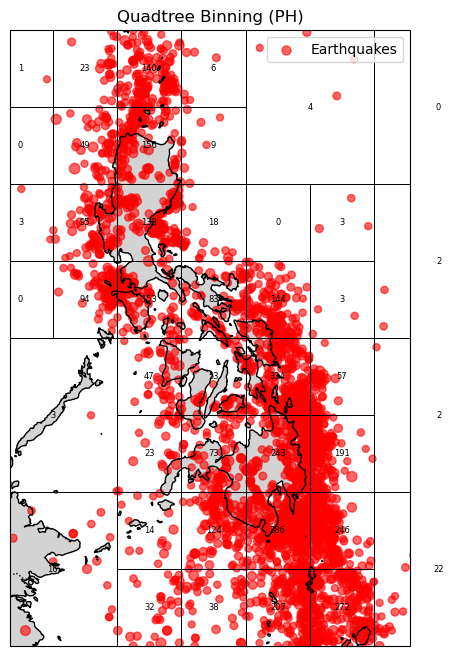

In [25]:
filtered_qt, region_qt, bounds_qt = apply_quadtree_binning(
    original_catalog, max_depth=3, min_events=50
)
plot_events_with_grid(filtered_qt, bounds_qt, title="Quadtree Binning", region_name="PH")

In [32]:
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up paths
project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from binning.quadtree import apply_quadtree

# Load earthquake catalog
data_csv = os.path.join(project_root, "data", "eq_catalog.csv")
catalog = pd.read_csv(data_csv, encoding="utf-8-sig")
catalog["Date_Time"] = pd.to_datetime(catalog[["Year", "Month", "Day", "Hour", "Minute", "Second"]], errors="coerce")
catalog["year"] = catalog["Date_Time"].dt.year
catalog = catalog.rename(columns={"N_Lat": "latitude", "E_Long": "longitude", "Mag": "magnitude"})

# Plotting function with Cartopy
def plot_events_with_grid(catalog, bounds, label, min_events, max_depth):
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([117.0, 130.0, 2.0, 22.0])
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Plot earthquakes
    ax.scatter(
        catalog["longitude"],
        catalog["latitude"],
        s=catalog["magnitude"]**2,
        color='red',
        alpha=0.6,
        label='Earthquakes'
    )

    # Plot and label bins
    for i, (min_lon, max_lon, min_lat, max_lat) in enumerate(bounds):
        rect = patches.Rectangle(
            (min_lon, min_lat),
            max_lon - min_lon,
            max_lat - min_lat,
            edgecolor='black',
            facecolor='none',
            linewidth=0.7,
            transform=ccrs.PlateCarree()
        )
        ax.add_patch(rect)

        sub = catalog.query(
            "longitude >= @min_lon & longitude < @max_lon & "
            "latitude  >= @min_lat  & latitude  < @max_lat"
        )
        event_count = len(sub)

        ax.text(
            (min_lon + max_lon) / 2,
            (min_lat + max_lat) / 2,
            f'{event_count}',
            ha='center', va='center',
            fontsize=6,
            transform=ccrs.PlateCarree()
        )

    ax.set_title(f"{label}\nmin_events={min_events}, max_depth={max_depth}", fontsize=10)
    ax.legend()
    return fig, ax

# Parameter combinations
param_grid = [
    {"label": "VeryHighEvent_LowDepth",    "min_events": 150, "max_depth": 2},
    {"label": "HighEvent_LowDepth",        "min_events": 100, "max_depth": 3},
    {"label": "MedEvent_MedDepth",         "min_events":  50, "max_depth": 4},
    {"label": "LowEvent_HighDepth",        "min_events":  20, "max_depth": 5},
    {"label": "VeryLowEvent_VeryHighDepth","min_events":  10, "max_depth": 6},
    {"label": "HighEvent_HighDepth",       "min_events": 100, "max_depth": 6},
    {"label": "LowEvent_LowDepth",         "min_events":  20, "max_depth": 3},
    {"label": "VeryLowEvent_LowDepth",     "min_events":  10, "max_depth": 2},
    {"label": "MedEvent_HighDepth",        "min_events":  50, "max_depth": 6},
]

# Run for each param set
for p in param_grid:
    me, md, label = p["min_events"], p["max_depth"], p["label"]
    print(f"\n=== PARAMETERS: {label} (min_events={me}, max_depth={md}) ===")

    filtered, qt_root, bounds = apply_quadtree(
        catalog, min_events=me, max_depth=md, min_bin_width=0.2
    )

    total_events = 0
    for i, (min_lon, max_lon, min_lat, max_lat) in enumerate(bounds, start=1):
        sub = catalog.query(
            "longitude >= @min_lon & longitude < @max_lon & "
            "latitude  >= @min_lat  & latitude  < @max_lat"
        )
        ev_count = len(sub)
        total_events += ev_count
        print(f"Bin {i:2d}: Lon {min_lon:.2f}-{max_lon:.2f}, Lat {min_lat:.2f}-{max_lat:.2f}, Events: {ev_count}")

    print(f"Total bins: {len(bounds)}   Total events in bins: {total_events}")

    # Plot & save
    fig, ax = plot_events_with_grid(catalog, bounds, label, me, md)
    out_fn = f"quadtree_{label}.png"
    plt.savefig(out_fn, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"\u2705 Saved plot: {out_fn}")


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 739)

3x3 GRID


BOUNDARIES for 3x3 Grid Binning:
Bin 1:
  Lon: 116.30 to 121.87
  Lat: 2.00 to 8.67
  Events: 38
Bin 2:
  Lon: 116.30 to 121.87
  Lat: 8.67 to 15.33
  Events: 288
Bin 3:
  Lon: 116.30 to 121.87
  Lat: 15.33 to 22.00
  Events: 429
Bin 4:
  Lon: 121.87 to 127.43
  Lat: 2.00 to 8.67
  Events: 1395
Bin 5:
  Lon: 121.87 to 127.43
  Lat: 8.67 to 15.33
  Events: 934
Bin 6:
  Lon: 121.87 to 127.43
  Lat: 15.33 to 22.00
  Events: 133
Bin 7:
  Lon: 127.43 to 133.00
  Lat: 2.00 to 8.67
  Events: 274
Bin 8:
  Lon: 127.43 to 133.00
  Lat: 8.67 to 15.33
  Events: 12
Bin 9:
  Lon: 127.43 to 133.00
  Lat: 15.33 to 22.00
  Events: 4


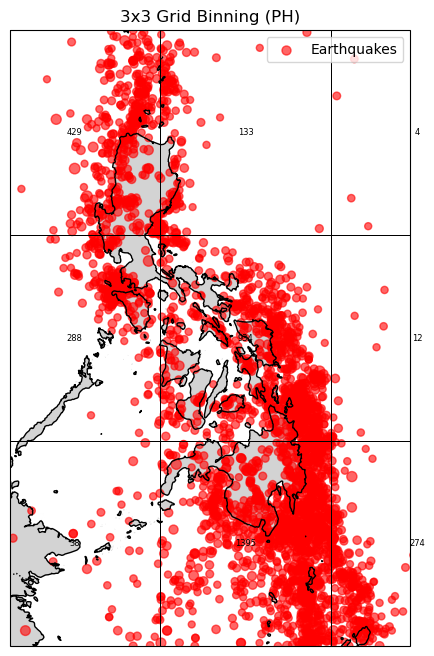

In [ ]:
filtered_grid, region_grid, bounds_grid = apply_cartesian(original_catalog)
plot_events_with_grid(filtered_grid, bounds_grid, title="3x3 Grid Binning", region_name="PH")
